In [2]:
import matplotlib.pyplot as plt
import h5py
import numpy as np
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

import icomo

plt.rcParams.update({'font.size': 8})

In [3]:
def bootstrap_confidence_interval(data, n=1000, func=np.mean, alpha=0.05):
    resamples = np.random.choice(data.dropna(), size=(n, len(data.dropna())), replace=True)
    perc = np.percentile([func(r) for r in resamples], [100*alpha/2, 100*(1-alpha/2)])
    return [func(data.dropna()) - perc[0], perc[1] - func(data.dropna())]

def percentile_confidence_interval(data, alpha=0.05):
    perc = np.percentile(data.dropna(), [100*alpha/2, 100*(1-alpha/2)])
    return [data.mean() - perc[0], perc[1] - data.mean()]

# System definition

In [4]:
# standard parameters
_RATE_RECOVER = 1.0 / 3.0
_RATE_LOAD = 1.0 / 0.5
_RATE_DOCK = 1.0 / 1.0
_RATE_PRIME = 1.0 / 0.1
_MAX_RECOVERY = 40.0
_MAX_LOADED = 40.0
_MAX_DOCKED = 20.0
_MAX_PRIMED = 4.0
_MAX_FUSED = 104.0
_RELEASE_PROBABILITY = 0.2

# Define the differential equations
def equations(t, y, args):
    t_args, const_args = args

    RATE_RECOVER = const_args["RATE_RECOVER"]
    RATE_LOAD = const_args["RATE_LOAD"]
    RATE_DOCK = const_args["RATE_DOCK"]
    RATE_PRIME = const_args["RATE_PRIME"]
    MAX_RECOVERY = const_args["MAX_RECOVERY"]
    MAX_LOADED = const_args["MAX_LOADED"]
    MAX_DOCKED = const_args["MAX_DOCKED"]
    MAX_PRIMED = const_args["MAX_PRIMED"]
    RELEASE_PROBABILITY = const_args["RELEASE_PROBABILITY"]

    stim_rate = t_args

    recovery = y["recovery"]
    loaded = y["loaded"]
    docked = y["docked"]
    primed = y["primed"]
    fused = y["fused"]

    # recovery
    fused_to_recovery = RATE_RECOVER * (fused > 0) * (recovery <= MAX_RECOVERY)
    recovery_to_loaded = 4 * RATE_LOAD * (recovery / MAX_RECOVERY) * (1 - loaded / MAX_LOADED)
    loaded_to_docked = 4 * RATE_DOCK * (loaded / MAX_LOADED) * (1 - docked / MAX_DOCKED)
    docked_to_primed = 4 * RATE_PRIME * (docked / MAX_DOCKED) * (1 - primed / MAX_PRIMED)

    drecovery = fused_to_recovery - recovery_to_loaded
    dloaded = recovery_to_loaded - loaded_to_docked
    ddocked = loaded_to_docked - docked_to_primed
    dprimed = docked_to_primed
    dfused = - fused_to_recovery

    # release
    release = RELEASE_PROBABILITY * primed * stim_rate(t)
    dprimed -= release
    dfused += release

    dy = {
        "recovery": drecovery,
        "loaded": dloaded,
        "docked": ddocked,
        "primed": dprimed,
        "fused": dfused,
    }
    
    return dy

# Depression test

In [5]:
len_sim = 10 * 60 # s
pps = 10 # points per second
num_points = int(len_sim * pps) 

### First set the time variables
t_solve_ODE = np.linspace(0, len_sim, num_points) # timepoints at which the ODE is solved
t_stim = t_solve_ODE # timepoints at which the stimulus is defined
t_out = t_solve_ODE # timepoints at which the output is saved

### Set parameters  for ODE
stim = 50 * np.ones(len(t_stim))
t_args = stim

const_args = {
    "RATE_RECOVER": _RATE_RECOVER,
    "RATE_LOAD": _RATE_LOAD,
    "RATE_DOCK": _RATE_DOCK,
    "RATE_PRIME": _RATE_PRIME,
    "MAX_RECOVERY": _MAX_RECOVERY,
    "MAX_LOADED": _MAX_LOADED,
    "MAX_DOCKED": _MAX_DOCKED,
    "MAX_PRIMED": _MAX_PRIMED,
    "RELEASE_PROBABILITY": _RELEASE_PROBABILITY,
}

### Define starting conditions
y0 = {"recovery": _MAX_RECOVERY, "loaded": _MAX_LOADED, "docked": _MAX_DOCKED, "primed": _MAX_PRIMED, "fused": 0.0}

# First parameters of the integrators have to be set
integrator_object = icomo.ODEIntegrator(
    ts_out=t_out,
    t_0=min(t_solve_ODE),
    ts_solver=t_solve_ODE,
    ts_arg=t_stim,
    max_steps=len(t_solve_ODE),
)

# Then we can obtain a function that solves our system of ODEs
integrator = integrator_object.get_func(equations)

# And solve the ODE for our starting conditions and parameters
y = integrator(y0=y0, arg_t=t_args, constant_args=const_args)
keys = ["recovery", "loaded", "docked", "primed", "fused"]
output = np.array([y[k] for k in keys]).T



/var/folders/k4/ysx53zxj6zz2qrpwl9q0jvzh0000gp/T/ipykernel_61763/4189122050.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


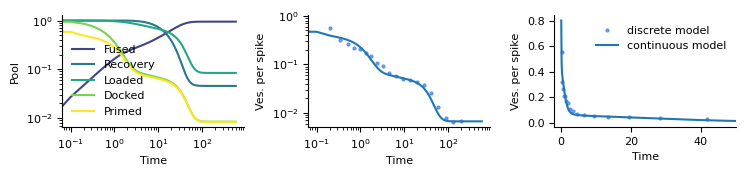

In [6]:

# pool sizes
f = plt.figure(figsize=(3*2.5,1.8))
axs = f.subplots(1,3)

normalization = np.array([_MAX_RECOVERY, _MAX_LOADED, _MAX_DOCKED, _MAX_PRIMED, _MAX_FUSED])
norm_out = output / normalization
# reorder fused pool first
norm_out = norm_out[:,[4,0,1,2,3]]
axs[0].plot(t_out, norm_out)
# log scale
axs[0].set_yscale("log")
axs[0].set_xscale("log")

import matplotlib.cm as cm
cmap = cm.get_cmap('viridis')
colors = [cmap(1 - (4-i)/5) for i in range(5)]
for i,j in enumerate(axs[0].lines):
    j.set_color(colors[i])

axs[0].set_xlabel("Time")
axs[0].set_ylabel("Pool")
axs[0].legend(["Fused", "Recovery", "Loaded", "Docked", "Primed"], frameon=False)
# remove top and right spines
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

# compare discrete and continuous release
filename = "../fig2/depression_test_50Hz.h5"
dic = h5py.File(filename, 'r')

ves_per_spike = dic.get('ves_per_spike')[()] 
ves_per_spike_mean = np.mean(ves_per_spike, axis=1)
ps = dic.get('ps')[()]
sizes = dic.get('sizes')[()]
test_times = dic.get('test_times')[()]

i_p = np.where(ps == 0.2)[0][0]
i_size = np.where(sizes == 1.0)[0][0]
sim_data = ves_per_spike_mean[:,i_p,i_size]

primed = output[:,3]
release_rate = primed * stim * _RELEASE_PROBABILITY
ves_per_spike = release_rate / stim

axs[1].plot(test_times, sim_data,
    linestyle='None', marker='o', zorder=2, markersize=2.0, label="discrete model", 
    color='cornflowerblue')
axs[1].plot(t_out, ves_per_spike, label="continuous model")
axs[1].set_yscale("log")
axs[1].set_xscale("log")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Ves. per spike");
# remove top and right spines
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)

# compare discrete and continuous release regular scale
axs[2].plot(test_times, sim_data,
    linestyle='None', marker='o', zorder=2, markersize=2.0, label="discrete model", 
    color='cornflowerblue')
inds = np.where(t_out <= 200)[0]
axs[2].plot(t_out[inds], ves_per_spike[inds], label="continuous model")
axs[2].legend(frameon=False)
axs[2].set_xlabel("Time")
axs[2].set_ylabel("Ves. per spike");
axs[2].set_xlim([-2,50])
# remove top and right spines
axs[2].spines['top'].set_visible(False)
axs[2].spines['right'].set_visible(False)

f.tight_layout()
f.savefig("compare_discrete_continuous.pdf")

# Adaptive depression test

/var/folders/k4/ysx53zxj6zz2qrpwl9q0jvzh0000gp/T/ipykernel_61763/1956948494.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('bone')


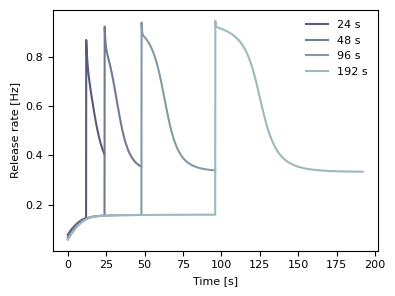

In [7]:
len_sim = 576*6 # s
pps = 10 # points per second
num_points = int(len_sim * pps)

### First set the time variables
t_out = np.linspace(0, len_sim, num_points) # timepoints of the output
t_solve_ODE = np.linspace(0, len_sim, num_points) # timepoints at which the ODE
                                                     # is solved
t_stim = t_solve_ODE # timepoints at which the stimulus is defined

### Set parameters  for ODE
stim = np.ones(len(t_stim))
stim_freq = 1 # Hz
n_blocks = 6
block_length = num_points // n_blocks
block_T = [2**i*6 for i in range(n_blocks)]
for i in range(n_blocks):
    stim[i*block_length:(i+1)*block_length] = [(t % block_T[i] > block_T[i] / 2) for t in t_stim[i*block_length:(i+1)*block_length]]

stim = stim * stim_freq + 0.2


t_args = stim

const_args = {
    "RATE_RECOVER": _RATE_RECOVER,
    "RATE_LOAD": _RATE_LOAD,
    "RATE_DOCK": _RATE_DOCK,
    "RATE_PRIME": _RATE_PRIME,
    "MAX_RECOVERY": _MAX_RECOVERY,
    "MAX_LOADED": _MAX_LOADED,
    "MAX_DOCKED": _MAX_DOCKED,
    "MAX_PRIMED": _MAX_PRIMED,
    "RELEASE_PROBABILITY": _RELEASE_PROBABILITY,
}

### Define starting conditions
y0 = {"recovery": _MAX_RECOVERY, "loaded": _MAX_LOADED, "docked": _MAX_DOCKED, "primed": _MAX_PRIMED, "fused": 0.0}

# First parameters of the integrators have to be set
integrator_object = icomo.ODEIntegrator(
    ts_out=t_out,
    t_0=min(t_solve_ODE),
    ts_solver=t_solve_ODE,
    ts_arg=t_stim,
    max_steps=len(t_solve_ODE),
)

# Then we can obtain a function that solves our system of ODEs
integrator = integrator_object.get_func(equations)

# And solve the ODE for our starting conditions and parameters
y = integrator(y0=y0, arg_t=t_args, constant_args=const_args)
primed = y["primed"]
release_rate = primed * stim * _RELEASE_PROBABILITY

f = plt.figure(figsize=(4,3))
labels = ["{} s".format(block_T[i]) for i in range(n_blocks)]
from matplotlib.cm import get_cmap
cmap = get_cmap('bone')
colors = cmap(np.linspace(0.2,0.7,n_blocks))
for i in range(2,n_blocks):
    plt.plot(t_out[:block_T[i]*pps], release_rate[i*block_length:i*block_length+block_T[i]*pps], color=colors[i], label=labels[i])
plt.legend(frameon=False)
plt.xlabel("Time [s]")
plt.ylabel("Release rate [Hz]");
plt.tight_layout()
plt.savefig("dynamic_release_rate.pdf")


# Fit to experiment

In [8]:
# get experimental data
excel_file = "data.xlsx" # change path to the location of your file
df = pd.read_excel(excel_file)
print(df)

        0.4_1    0.4_10    0.4_40   0.4_100       4_1      4_10      4_40  \
0   -0.004322  0.015975  0.030165  0.107100  0.012300  0.034671  0.092720   
1   -0.033552  0.098034  0.015343  0.028300  0.001113  0.059402  0.185230   
2    0.047367  0.011189  0.023875 -0.008995  0.059700  0.051453  0.001816   
3   -0.006672  0.027273 -0.006411  0.025600 -0.003746  0.042129  0.134290   
4   -0.029773 -0.024372 -0.000859  0.081300  0.016900  0.074912  0.046155   
..        ...       ...       ...       ...       ...       ...       ...   
542       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
543       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
544       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
545       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
546       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

        4_100      40_1     40_10     40_40    40_100    40_200  
0    0.03

In [9]:
pps = 10 # points per second

def get_integrator_object(depletiontime, pausetime, testtime):
    len_sim = depletiontime + pausetime + testtime # s
    num_points = int(len_sim * pps)

    t_solve_ODE = np.linspace(0, len_sim, num_points) # timepoints at which the ODE is solved
    t_stim = t_solve_ODE # timepoints at which the stimulus is defined

    # only return the output during the test time
    t_out_inds = np.logical_and((t_solve_ODE > depletiontime + pausetime), (t_solve_ODE < depletiontime + pausetime + testtime))
    t_out = t_solve_ODE[t_out_inds]

    integrator_object = icomo.ODEIntegrator(
        ts_out=t_out,
        t_0=min(t_solve_ODE),
        ts_solver=t_solve_ODE,
        ts_arg=t_stim,
        max_steps=len(t_solve_ODE),
    )
    return integrator_object, t_solve_ODE

def get_lognormal_params(mean, std):
    sigma = np.sqrt(np.log(std**2 / mean**2 + 1))
    mu = np.log(mean) - 0.5 * sigma**2
    return mu, sigma

with pm.Model() as model:

    # Priors on the model parameters
    precision = 2
    mu, sigma = get_lognormal_params(_MAX_RECOVERY, _MAX_RECOVERY/precision)
    max_recovery = pm.LogNormal("max_recovery", mu=mu, sigma=sigma)
    mu, sigma = get_lognormal_params(_MAX_LOADED, _MAX_LOADED/precision)
    max_loaded = pm.LogNormal("max_loaded", mu=mu, sigma=sigma)
    mu, sigma = get_lognormal_params(_MAX_DOCKED, _MAX_DOCKED/precision)
    max_docked = pm.LogNormal("max_docked", mu=mu, sigma=sigma)
    mu, sigma = get_lognormal_params(_MAX_PRIMED, _MAX_PRIMED/precision)
    max_primed = pm.LogNormal("max_primed", mu=mu, sigma=sigma)
    
    precision = 1
    mu, sigma = get_lognormal_params(_RATE_RECOVER, _RATE_RECOVER/precision)
    rate_recover = pm.LogNormal("rate_recover", mu=mu, sigma=sigma)
    mu, sigma = get_lognormal_params(_RATE_LOAD, _RATE_LOAD/precision)
    rate_load = pm.LogNormal("rate_load", mu=mu, sigma=sigma)
    mu, sigma = get_lognormal_params(_RATE_DOCK, _RATE_DOCK/precision)
    rate_dock = pm.LogNormal("rate_dock", mu=mu, sigma=sigma)
    mu, sigma = get_lognormal_params(_RATE_PRIME, _RATE_PRIME/precision)
    rate_prime = pm.LogNormal("rate_prime", mu=mu, sigma=sigma)
    
    release_probability = pm.Beta("release_probability", alpha=2, beta=5)
    # additional factor to scale from num vesicles to calcium data
    observation_factor = pm.Flat("observation_factor")
    error_model = pm.HalfCauchy("error_model", beta=0.1)

    const_args_var = {
        "RATE_RECOVER": rate_recover,
        "RATE_LOAD": rate_load,
        "RATE_DOCK": rate_dock,
        "RATE_PRIME": rate_prime,
        "MAX_RECOVERY": max_recovery,
        "MAX_LOADED": max_loaded,
        "MAX_DOCKED": max_docked,
        "MAX_PRIMED": max_primed,
        "RELEASE_PROBABILITY": release_probability,
    }

    testtime = 2.0 # s
    depletiontimes = [0.4, 4.0, 40.0]
    pausetimes = [1.0, 10.0, 40.0, 100.0]
    stim_rate = 20.0 # Hz
    conditions = [(depletiontime, pausetime) for pausetime in pausetimes for depletiontime in depletiontimes]
    conditions.append((40.0, 200.0))

    sim = []
    sim_error = []
    obs = []

    for condition in conditions:
        depletiontime, pausetime = condition
        # get condition name
        fm = lambda x: round(x, 1) if x % 1 else int(x)
        condition_name = "{}_{}".format(fm(depletiontime), fm(pausetime))

        y0 = {"recovery": max_recovery, "loaded": max_loaded, "docked": max_docked, "primed": max_primed, "fused": 0.0}
        
        # define integrator object
        integrator_object, ts = get_integrator_object(depletiontime, pausetime, testtime)
        integrator_op = integrator_object.get_op(equations, list_keys_to_return=["primed", "fused"], return_shapes=[() for _ in range(2)])
        
        # define stimulus
        stim = ts < depletiontime
        stim = stim + (ts > depletiontime + pausetime)
        stim = stim * stim_rate

        # And solve the ODE for our starting conditions and parameters
        primed, fused = integrator_op(y0=y0, arg_t=stim, constant_args=const_args_var)
        release_rate = primed * stim_rate * release_probability
        released = pm.math.mean(release_rate)

        # save sim data under condition name
        pm.Deterministic(condition_name, observation_factor * released)

        # get data and simulation results
        data = df[condition_name]
        error_of_the_mean = np.std(data) / np.sqrt(len(data))
        data_mean = np.mean(data)
        sigma_error = pm.Deterministic("scaled_sigma_error_" + condition_name, error_model + error_of_the_mean)
        
        sim.append(observation_factor * released)
        sim_error.append(sigma_error)
        obs.append(data_mean)

    sim = pm.math.stack(sim)
    sim_error = pm.math.stack(sim_error)

    pm.Normal("likelihood",
                mu = sim, 
                sigma = sim_error,
                observed = obs)

In [10]:
# # sample the model
# trace = pm.sample(
#     model=model,
#     tune=300,
#     draws=1000,
#     cores=4,
#     nuts_sampler_kwargs={"nuts_kwargs": {"max_tree_depth": 6}},
#     nuts_sampler="numpyro",
#     target_accept=0.9,
# )

# # save the trace
# trace = az.to_netcdf(trace, "trace.nc")

# load the trace
trace = az.from_netcdf("trace.nc")

In [11]:
print(az.rhat(trace))

<xarray.Dataset>
Dimensions:                     ()
Data variables: (12/37)
    0.4_1                       float64 1.028
    0.4_10                      float64 1.005
    0.4_100                     float64 1.007
    0.4_40                      float64 1.007
    40_1                        float64 1.006
    40_10                       float64 1.007
    ...                          ...
    scaled_sigma_error_40_200   float64 1.043
    scaled_sigma_error_40_40    float64 1.043
    scaled_sigma_error_4_1      float64 1.043
    scaled_sigma_error_4_10     float64 1.043
    scaled_sigma_error_4_100    float64 1.043
    scaled_sigma_error_4_40     float64 1.043


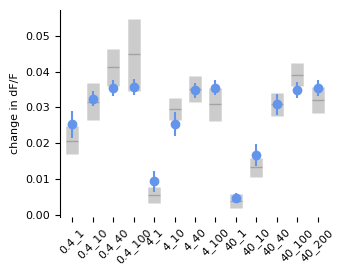

In [12]:
# get the posterior
sim_df = pd.DataFrame()
for condition in conditions:
    depletiontime, pausetime = condition
    condition_name = "{}_{}".format(fm(depletiontime), fm(pausetime))
    sim_df[condition_name] = trace.posterior[condition_name].to_numpy().flatten()

fig = plt.figure(figsize=(3.5,2.8))
ax = fig.subplots(1,1)

# offset points
import matplotlib.transforms as transforms
offset = lambda p: transforms.ScaledTranslation(p/72.,0, fig.dpi_scale_trans)
trans = ax.transData

# remove the right and top and bottom spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

errs_df = df.apply(lambda x: bootstrap_confidence_interval(x), axis=0)
plt.errorbar(df.columns, df.mean(), yerr=errs_df, linestyle='None', marker='None', markersize=2, elinewidth=9, color='black', alpha=0.2)
plt.errorbar(df.columns, df.mean(), yerr=errs_df, linestyle='None', marker='_', markersize=9, elinewidth=0, color='black', alpha=0.2)

errs_sim_df = sim_df.apply(lambda x: percentile_confidence_interval(x), axis=0)
plt.errorbar(sim_df.columns, sim_df.mean(), yerr=sim_df.std(), linestyle='None', marker='o', color='cornflowerblue')

plt.xticks(rotation=45)
plt.ylabel("change in dF/F")
plt.tight_layout()
plt.savefig("posterior_full_comparison.pdf", bbox_inches='tight')


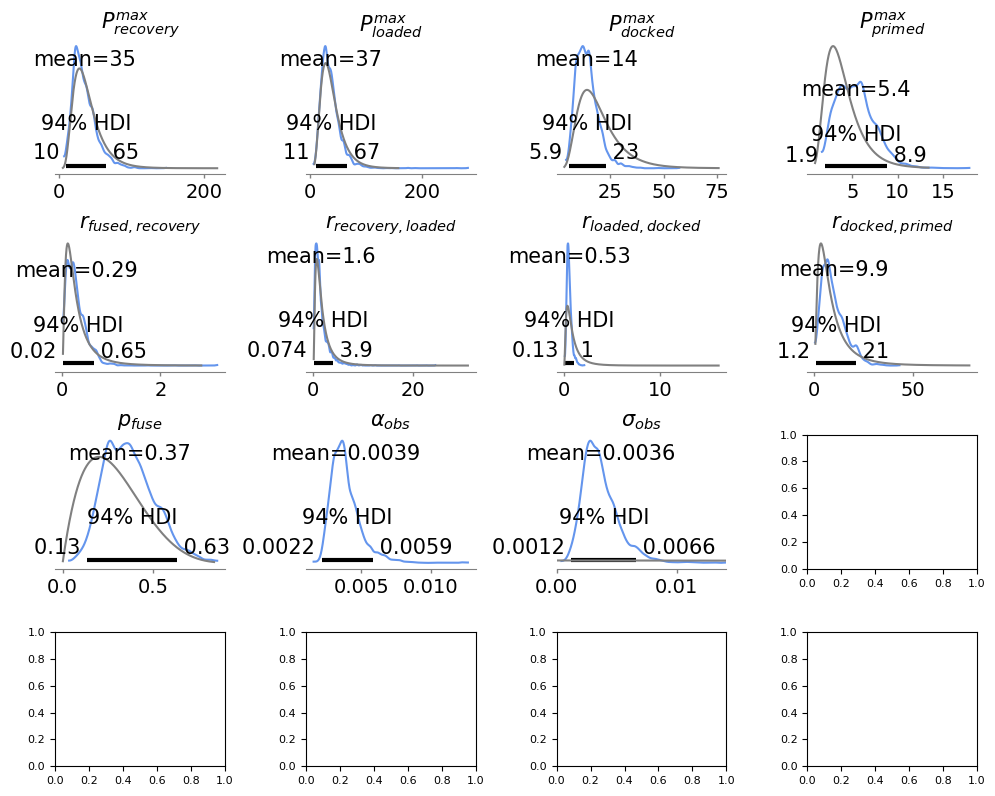

In [13]:
def plot_cont(prior, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    samples = pm.draw(prior, draws=1000)
    x = np.linspace(np.min(samples), np.max(samples), 1000)
    ax.plot(x, np.exp(pm.logp(prior,x)).eval(), color='gray')
    return ax

condition_names = ["{}_{}".format(fm(condition[0]), fm(condition[1])) for condition in conditions]

name_dict = {
    "max_recovery": r"$P^{max}_{recovery}$",
    "max_loaded": r"$P^{max}_{loaded}$",
    "max_docked": r"$P^{max}_{docked}$",
    "max_primed": r"$P^{max}_{primed}$",
    "rate_recover": r"$r_{fused,recovery}$",
    "rate_load": r"$r_{recovery,loaded}$",
    "rate_dock": r"$r_{loaded,docked}$",
    "rate_prime": r"$r_{docked,primed}$",
    "release_probability": r"$p_{fuse}$",
    "observation_factor": r"$\alpha_{obs}$",
    "error_model": r"$\sigma_{obs}$",
}

# for each variable plot prior and posterior
names = [var.name for var in model.unobserved_RVs]
fl = lambda name: not any([condition_name in name for condition_name in condition_names])
names = list(filter(fl, names))

sidelength = int(np.ceil(np.sqrt(len(names))))
fig, axs = plt.subplots(sidelength, sidelength, figsize=(sidelength*2.5, sidelength*2));
axs = axs.flatten()

for name, i in zip(names, range(len(names))):
    ax = axs[i]

    pm.plot_posterior(trace, var_names=name, color='cornflowerblue', ax=ax)
    ax.set_title(name_dict[name], fontdict={'fontsize': 15})
    # plot prior
    prior = model[name]
    try:
        plot_cont(prior, ax=ax)
    except:
        pass
    # scale to posterior
    if name == "error_model":
        ax.set_xlim((0, np.max(trace.posterior[name])))

plt.tight_layout();
plt.savefig("posterior_full.pdf", bbox_inches='tight')



In [14]:
print(az.summary(trace))
# keys = list(const_args_var.keys())
# keys = [k.lower() for k in keys]
# az.plot_forest(trace, var_names=keys, combined=True, hdi_prob=0.95, transform=lambda x: np.log10(x))
# az.plot_forest(trace, var_names=["error_model"], combined=True, hdi_prob=0.95)

                              mean      sd  hdi_3%  hdi_97%  mcse_mean  \
0.4_1                        0.025   0.004   0.018    0.032      0.000   
0.4_10                       0.032   0.002   0.028    0.036      0.000   
0.4_100                      0.036   0.002   0.032    0.040      0.000   
0.4_40                       0.035   0.002   0.031    0.040      0.000   
40_1                         0.005   0.001   0.003    0.007      0.000   
40_10                        0.017   0.003   0.011    0.022      0.000   
40_100                       0.035   0.002   0.031    0.039      0.000   
40_200                       0.035   0.002   0.031    0.039      0.000   
40_40                        0.031   0.003   0.026    0.036      0.000   
4_1                          0.009   0.003   0.005    0.014      0.000   
4_10                         0.025   0.003   0.019    0.032      0.000   
4_100                        0.036   0.002   0.032    0.040      0.000   
4_40                         0.035   0

# Single timescale fit

In [15]:
# standard parameters
_RATE_PRIME_SINGLE = 1.0 / 2.0
_MAX_PRIMED_SINGLE = 10.0
_MAX_FUSED_SINGLE = 100.0
_RELEASE_PROBABILITY_SINGLE = 0.2

# Define the differential equations
def equations_single(t, y, args):
    t_args, const_args = args

    RATE_PRIME = const_args["RATE_PRIME"]
    MAX_PRIMED = const_args["MAX_PRIMED"]
    RELEASE_PROBABILITY = const_args["RELEASE_PROBABILITY"]

    stim_rate = t_args

    primed = y["primed"]
    fused = y["fused"]

    # recovery
    fused_to_primed = RATE_PRIME * (fused > 0) * (1 - primed / MAX_PRIMED)

    dprimed = fused_to_primed
    dfused = - fused_to_primed

    # release
    release = RELEASE_PROBABILITY * primed * stim_rate(t)
    dprimed -= release
    dfused += release

    dy = {
        "primed": dprimed,
        "fused": dfused,
    }
    
    return dy

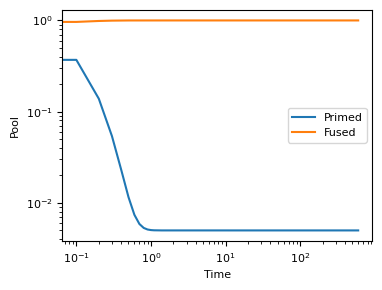

In [16]:
len_sim = 10 * 60 # s
pps = 10 # points per second
num_points = int(len_sim * pps) 

### First set the time variables
t_solve_ODE = np.linspace(0, len_sim, num_points) # timepoints at which the ODE is solved
t_stim = t_solve_ODE # timepoints at which the stimulus is defined
t_out = t_solve_ODE # timepoints at which the output is saved

### Set parameters  for ODE
stim = 50 * np.ones(len(t_stim))
t_args = stim

const_args = {
    "RATE_PRIME": _RATE_PRIME_SINGLE,
    "MAX_PRIMED": _MAX_PRIMED_SINGLE,
    "RELEASE_PROBABILITY": _RELEASE_PROBABILITY_SINGLE,
}

### Define starting conditions
y0 = {"primed": _MAX_PRIMED_SINGLE, "fused": _MAX_FUSED_SINGLE-_MAX_PRIMED_SINGLE}

# First parameters of the integrators have to be set
integrator_object = icomo.ODEIntegrator(
    ts_out=t_out,
    t_0=min(t_solve_ODE),
    ts_solver=t_solve_ODE,
    ts_arg=t_stim,
    max_steps=len(t_solve_ODE),
)

# Then we can obtain a function that solves our system of ODEs
integrator = integrator_object.get_func(equations_single)

# And solve the ODE for our starting conditions and parameters
y = integrator(y0=y0, arg_t=t_args, constant_args=const_args)
keys = ["primed", "fused"]
output = np.array([y[k] for k in keys]).T

f = plt.figure(figsize=(4,3))
normalization = np.array([_MAX_PRIMED_SINGLE, _MAX_FUSED_SINGLE])
plt.plot(t_out, output / normalization)
# log scale
plt.yscale("log")
plt.xscale("log")
plt.legend(["Primed", "Fused"])
plt.xlabel("Time")
plt.ylabel("Pool");

In [17]:
pps = 10 # points per second

with pm.Model() as model_single:

    # Priors on the model parameters
    precision = 1
    mu, sigma = get_lognormal_params(_MAX_PRIMED_SINGLE, _MAX_PRIMED_SINGLE/precision)
    max_primed = pm.LogNormal("max_primed", mu=mu, sigma=sigma)
    
    precision = 1
    mu, sigma = get_lognormal_params(_RATE_PRIME_SINGLE, _RATE_PRIME_SINGLE/precision)
    rate_prime = pm.LogNormal("rate_prime", mu=mu, sigma=sigma)
    
    release_probability = pm.Beta("release_probability", alpha=2, beta=5)
    # additional factor to scale from num vesicles to calcium data
    observation_factor = pm.Flat("observation_factor")
    error_model = pm.HalfCauchy("error_model", beta=0.1)

    const_args_var = {
        "RATE_PRIME": rate_prime,
        "MAX_PRIMED": max_primed,
        "RELEASE_PROBABILITY": release_probability,
    }

    testtime = 2.0 # s
    depletiontimes = [0.4, 4.0, 40.0]
    pausetimes = [1.0, 10.0, 40.0, 100.0]
    stim_rate = 20.0 # Hz
    # mu, sigma = get_lognormal_params(stim_rate, stim_rate/4)
    # stim_rate = pm.LogNormal("stim_rate", mu=mu, sigma=sigma)
    conditions = [(depletiontime, pausetime) for pausetime in pausetimes for depletiontime in depletiontimes]
    conditions.append((40.0, 200.0))

    sim = []
    sim_error = []
    obs = []

    for condition in conditions:
        depletiontime, pausetime = condition
        # get condition name
        fm = lambda x: round(x, 1) if x % 1 else int(x)
        condition_name = "{}_{}".format(fm(depletiontime), fm(pausetime))

        y0 = {"primed": max_primed, "fused": _MAX_FUSED_SINGLE - max_primed}
        
        # define integrator object
        integrator_object, ts = get_integrator_object(depletiontime, pausetime, testtime)
        integrator_op = integrator_object.get_op(equations_single, list_keys_to_return=["primed", "fused"], return_shapes=[() for _ in range(2)])
        
        # define stimulus
        stim = ts < depletiontime
        stim = stim + (ts > depletiontime + pausetime)
        stim = stim * stim_rate

        # And solve the ODE for our starting conditions and parameters
        primed, fused = integrator_op(y0=y0, arg_t=stim, constant_args=const_args_var)
        release_rate = primed * stim_rate * release_probability
        released = pm.math.mean(release_rate)

        # save sim data under condition name
        pm.Deterministic(condition_name, observation_factor * released)

        # get data and simulation results
        data = df[condition_name]
        error_of_the_mean = np.std(data) / np.sqrt(len(data))
        data_mean = np.mean(data)
        sigma_error = pm.Deterministic("scaled_sigma_error_" + condition_name, error_model + error_of_the_mean)

        sim.append(observation_factor * released)
        sim_error.append(sigma_error)
        obs.append(data_mean)

    sim = pm.math.stack(sim)
    sim_error = pm.math.stack(sim_error)

    # define likelihood    
    pm.Normal("likelihood",
                mu = sim, 
                sigma = sim_error,
                observed = obs)

In [18]:
# # sample the model
# trace_single = pm.sample(
#     model=model_single,
#     tune=300,
#     draws=1000,
#     cores=4,
#     nuts_sampler_kwargs={"nuts_kwargs": {"max_tree_depth": 6}},
#     nuts_sampler="numpyro",
#     target_accept=0.9,
# )

# # save the trace
# az.to_netcdf(trace_single, "trace_single.nc")

# load the trace
trace_single = az.from_netcdf("trace_single.nc")

In [19]:
print(az.rhat(trace_single))

<xarray.Dataset>
Dimensions:                     ()
Data variables: (12/31)
    0.4_1                       float64 1.007
    0.4_10                      float64 1.004
    0.4_100                     float64 1.001
    0.4_40                      float64 1.001
    40_1                        float64 1.002
    40_10                       float64 1.001
    ...                          ...
    scaled_sigma_error_40_200   float64 1.006
    scaled_sigma_error_40_40    float64 1.006
    scaled_sigma_error_4_1      float64 1.006
    scaled_sigma_error_4_10     float64 1.006
    scaled_sigma_error_4_100    float64 1.006
    scaled_sigma_error_4_40     float64 1.006


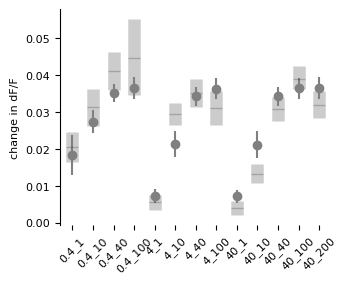

In [20]:
# get the posterior
sim_df = pd.DataFrame()
for condition in conditions:
    depletiontime, pausetime = condition
    condition_name = "{}_{}".format(fm(depletiontime), fm(pausetime))
    sim_df[condition_name] = trace_single.posterior[condition_name].to_numpy().flatten()

fig = plt.figure(figsize=(3.5,2.8))
ax = fig.subplots(1,1)

# remove the right and top and bottom spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

errs_df = df.apply(lambda x: bootstrap_confidence_interval(x), axis=0)
plt.errorbar(df.columns, df.mean(), yerr=errs_df, linestyle='None', marker='None', markersize=2, elinewidth=9, color='black', alpha=0.2)
plt.errorbar(df.columns, df.mean(), yerr=errs_df, linestyle='None', marker='_', markersize=9, elinewidth=0, color='black', alpha=0.2)

errs_sim_df = sim_df.apply(lambda x: percentile_confidence_interval(x), axis=0)
plt.errorbar(sim_df.columns, sim_df.mean(), yerr=sim_df.std(), linestyle='None', marker='o', color='gray')

plt.xticks(rotation=45)
plt.ylabel("change in dF/F")

plt.savefig("posterior_single_comparison.pdf", bbox_inches='tight')

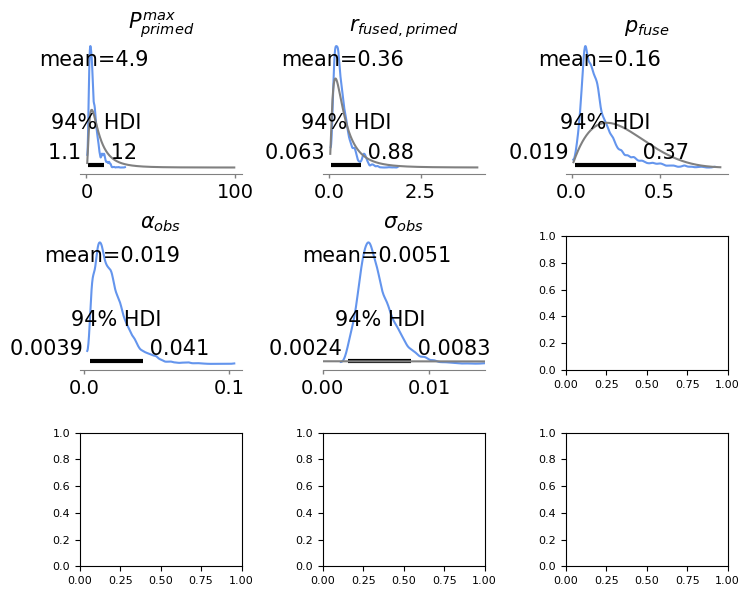

In [21]:
condition_names = ["{}_{}".format(fm(condition[0]), fm(condition[1])) for condition in conditions]

name_dict = {
    "max_primed": r"$P^{max}_{primed}$",
    "rate_prime": r"$r_{fused,primed}$",
    "release_probability": r"$p_{fuse}$",
    "observation_factor": r"$\alpha_{obs}$",
    "error_model": r"$\sigma_{obs}$",
}

# for each variable plot prior and posterior
names_single = [var.name for var in model_single.unobserved_RVs]
fl = lambda name: not any([condition_name in name for condition_name in condition_names])
names_single = list(filter(fl, names_single))

sidelength = int(np.ceil(np.sqrt(len(names_single))))
fig, axs = plt.subplots(sidelength, sidelength, figsize=(sidelength*2.5, sidelength*2));
axs = axs.flatten()

for name, i in zip(names_single, range(len(names_single))):
    ax = axs[i]

    pm.plot_posterior(trace_single, var_names=name, color='cornflowerblue', ax=ax)
    ax.set_title(name_dict[name], fontdict={'fontsize': 15})
    # plot prior
    prior = model_single[name]
    try:
        plot_cont(prior, ax=ax)
    except:
        pass
    # scale to posterior
    if name == "error_model":
        ax.set_xlim((0, np.max(trace_single.posterior[name])))

plt.tight_layout();
plt.savefig("posterior_single.pdf", bbox_inches='tight')

# Two timescales

In [22]:
# standard parameters
_RATE_RECOVER_TT = 1.0 / 3.0
_RATE_PRIME_TT = 1.0 / 0.5
_MAX_RECOVERY_TT = 40.0
_MAX_PRIMED_TT = 4.0
_MAX_FUSED_TT = 104.0
_RELEASE_PROBABILITY_TT = 0.2

# Define the differential equations
def equations_tt(t, y, args):
    t_args, const_args = args

    RATE_RECOVER = const_args["RATE_RECOVER"]
    RATE_PRIME = const_args["RATE_PRIME"]
    MAX_RECOVERY = const_args["MAX_RECOVERY"]
    MAX_PRIMED = const_args["MAX_PRIMED"]
    RELEASE_PROBABILITY = const_args["RELEASE_PROBABILITY"]

    stim_rate = t_args

    recovery = y["recovery"]
    primed = y["primed"]
    fused = y["fused"]

    # recovery
    fused_to_recovery = RATE_RECOVER * (fused > 0) * (recovery < MAX_RECOVERY)
    recovery_to_primed = 4 * RATE_PRIME * (recovery / MAX_RECOVERY) * (1 - primed / MAX_PRIMED)

    drecovery = fused_to_recovery - recovery_to_primed
    dprimed = recovery_to_primed
    dfused = - fused_to_recovery

    # release
    release = RELEASE_PROBABILITY * primed * stim_rate(t)
    dprimed -= release
    dfused += release

    dy = {
        "recovery": drecovery,
        "primed": dprimed,
        "fused": dfused,
    }
    
    return dy

In [23]:
with pm.Model() as model_tt:

    # Priors on the model parameters
    precision = 2
    mu, sigma = get_lognormal_params(_MAX_RECOVERY_TT, _MAX_RECOVERY_TT/precision)
    max_recovery = pm.LogNormal("max_recovery", mu=mu, sigma=sigma)
    mu, sigma = get_lognormal_params(_MAX_PRIMED_TT, _MAX_PRIMED_TT/precision)
    max_primed = pm.LogNormal("max_primed", mu=mu, sigma=sigma)
    
    precision = 1
    mu, sigma = get_lognormal_params(_RATE_RECOVER_TT, _RATE_RECOVER_TT/precision)
    rate_recover = pm.LogNormal("rate_recover", mu=mu, sigma=sigma)
    mu, sigma = get_lognormal_params(_RATE_PRIME_TT, _RATE_PRIME_TT/precision)
    rate_prime = pm.LogNormal("rate_prime", mu=mu, sigma=sigma)
    
    release_probability = pm.Beta("release_probability", alpha=2, beta=5)
    # additional factor to scale from num vesicles to calcium data
    observation_factor = pm.Flat("observation_factor")
    error_model = pm.HalfCauchy("error_model", beta=0.1)

    const_args_var = {
        "RATE_RECOVER": rate_recover,
        "RATE_PRIME": rate_prime,
        "MAX_RECOVERY": max_recovery,
        "MAX_PRIMED": max_primed,
        "RELEASE_PROBABILITY": release_probability,
    }

    testtime = 2.0 # s
    depletiontimes = [0.4, 4.0, 40.0]
    pausetimes = [1.0, 10.0, 40.0, 100.0]
    stim_rate = 20.0 # Hz
    conditions = [(depletiontime, pausetime) for pausetime in pausetimes for depletiontime in depletiontimes]
    conditions.append((40.0, 200.0))

    sim = []
    sim_error = []
    obs = []

    for condition in conditions:
        depletiontime, pausetime = condition
        # get condition name
        fm = lambda x: round(x, 1) if x % 1 else int(x)
        condition_name = "{}_{}".format(fm(depletiontime), fm(pausetime))

        y0 = {"recovery": max_recovery, "primed": max_primed, "fused": 0.0}
        
        # define integrator object
        integrator_object, ts = get_integrator_object(depletiontime, pausetime, testtime)
        integrator_op = integrator_object.get_op(equations_tt, list_keys_to_return=["primed", "fused"], return_shapes=[() for _ in range(2)])
        
        # define stimulus
        stim = ts < depletiontime
        stim = stim + (ts > depletiontime + pausetime)
        stim = stim * stim_rate

        # And solve the ODE for our starting conditions and parameters
        primed, fused = integrator_op(y0=y0, arg_t=stim, constant_args=const_args_var)
        release_rate = primed * stim_rate * release_probability
        released = pm.math.mean(release_rate)

        # save sim data under condition name
        pm.Deterministic(condition_name, observation_factor * released)

        # get data and simulation results
        data = df[condition_name]
        error_of_the_mean = np.std(data) / np.sqrt(len(data))
        data_mean = np.mean(data)
        sigma_error = pm.Deterministic("scaled_sigma_error_" + condition_name, error_model + error_of_the_mean)
        
        sim.append(observation_factor * released)
        sim_error.append(sigma_error)
        obs.append(data_mean)

    sim = pm.math.stack(sim)
    sim_error = pm.math.stack(sim_error)

    # define likelihood
    pm.Normal("likelihood",
                mu = sim, 
                sigma = sim_error,
                observed = obs)

In [24]:
# # sample the model
# trace_tt = pm.sample(
#     model=model_tt,
#     tune=300,
#     draws=1000,
#     cores=4,
#     nuts_sampler_kwargs={"nuts_kwargs": {"max_tree_depth": 6}},
#     nuts_sampler="numpyro",
#     target_accept=0.9,
# )

# # save the trace
# az.to_netcdf(trace_tt, "trace_tt.nc")

# load the trace
trace_tt = az.from_netcdf("trace_tt.nc")

In [25]:
print(az.rhat(trace_tt))

<xarray.Dataset>
Dimensions:                     ()
Data variables: (12/33)
    0.4_1                       float64 1.04
    0.4_10                      float64 1.025
    0.4_100                     float64 1.012
    0.4_40                      float64 1.009
    40_1                        float64 1.051
    40_10                       float64 1.035
    ...                          ...
    scaled_sigma_error_40_200   float64 1.048
    scaled_sigma_error_40_40    float64 1.048
    scaled_sigma_error_4_1      float64 1.048
    scaled_sigma_error_4_10     float64 1.048
    scaled_sigma_error_4_100    float64 1.048
    scaled_sigma_error_4_40     float64 1.048


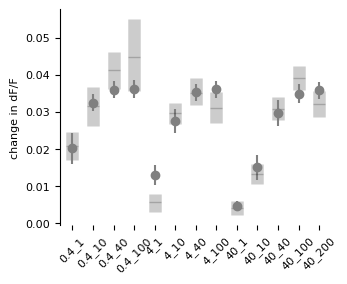

In [26]:
# get the posterior
sim_df = pd.DataFrame()
for condition in conditions:
    depletiontime, pausetime = condition
    condition_name = "{}_{}".format(fm(depletiontime), fm(pausetime))
    sim_df[condition_name] = trace_tt.posterior[condition_name].to_numpy().flatten()

fig = plt.figure(figsize=(3.5,2.8))
ax = fig.subplots(1,1)

# remove the right and top and bottom spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

errs_df = df.apply(lambda x: bootstrap_confidence_interval(x), axis=0)
plt.errorbar(df.columns, df.mean(), yerr=errs_df, linestyle='None', marker='None', markersize=2, elinewidth=9, color='black', alpha=0.2)
plt.errorbar(df.columns, df.mean(), yerr=errs_df, linestyle='None', marker='_', markersize=9, elinewidth=0, color='black', alpha=0.2)

errs_sim_df = sim_df.apply(lambda x: percentile_confidence_interval(x), axis=0)
plt.errorbar(sim_df.columns, sim_df.mean(), yerr=sim_df.std(), linestyle='None', marker='o', color='gray')

plt.xticks(rotation=45)
plt.ylabel("change in dF/F")
plt.savefig("posterior_tt.pdf", bbox_inches='tight')


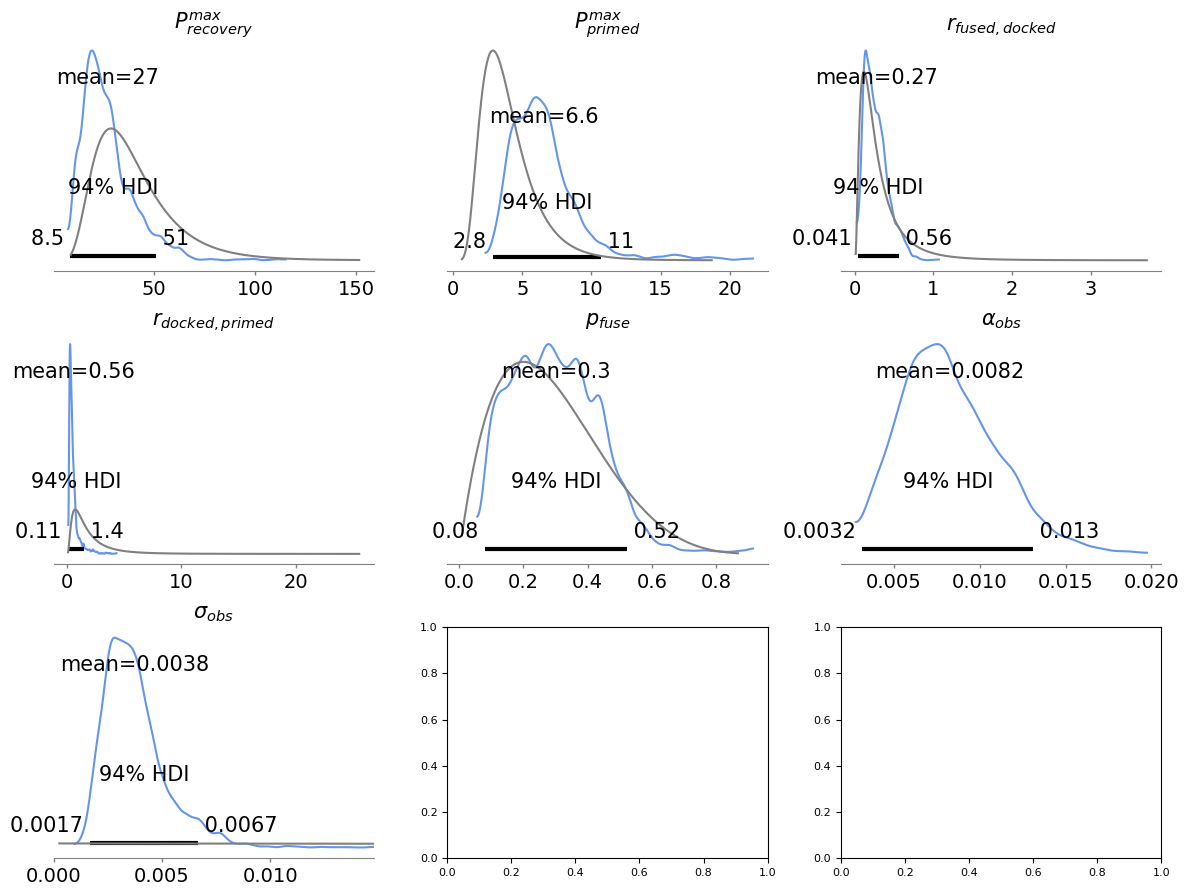

In [27]:
condition_names = ["{}_{}".format(fm(condition[0]), fm(condition[1])) for condition in conditions]

name_dict = {
    "max_recovery": r"$P^{max}_{recovery}$",
    "max_primed": r"$P^{max}_{primed}$",
    "rate_recover": r"$r_{fused,docked}$",
    "rate_prime": r"$r_{docked,primed}$",
    "release_probability": r"$p_{fuse}$",
    "observation_factor": r"$\alpha_{obs}$",
    "error_model": r"$\sigma_{obs}$",
}

# for each variable plot prior and posterior
names_tt = [var.name for var in model_tt.unobserved_RVs]
fl = lambda name: not any([condition_name in name for condition_name in condition_names])
names_tt = list(filter(fl, names_tt))

sidelength = int(np.ceil(np.sqrt(len(names_tt))))
fig, axs = plt.subplots(sidelength, sidelength, figsize=(sidelength*4, sidelength*3));
axs = axs.flatten()

for name, i in zip(names_tt, range(len(names_tt))):
    ax = axs[i]

    pm.plot_posterior(trace_tt, var_names=name, color='cornflowerblue', ax=ax)
    ax.set_title(name_dict[name], fontdict={'fontsize': 15})
    # plot prior
    prior = model_tt[name]
    try:
        plot_cont(prior, ax=ax)
    except:
        pass
    # scale to posterior
    if name == "error_model":
        ax.set_xlim((0, np.max(trace_tt.posterior[name])))

plt.tight_layout();
plt.savefig("posterior_tt_full.pdf", bbox_inches='tight')

# Model comparision

In [28]:
with model:
    if not "log_likelihood" in trace._groups:
        log_likelihood = pm.compute_log_likelihood(trace)
        # trace.to_netcdf("trace.nc")
model_loo = az.loo(trace)

with model_single:
    if not "log_likelihood" in trace_single._groups:
        log_likelihood_single = pm.compute_log_likelihood(trace_single)
        # trace_single.to_netcdf("trace_single.nc")
model_single_loo = az.loo(trace_single)

with model_tt:
    if not "log_likelihood" in trace_tt._groups:
        log_likelihood_tt = pm.compute_log_likelihood(trace_tt)
        # trace_tt.to_netcdf("trace_tt.nc")
model_tt_loo = az.loo(trace_tt)


/opt/homebrew/anaconda3/lib/python3.10/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.10/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.10/site-packages/arviz/sta

In [29]:
comp_loo = az.compare({"full": trace, "single timescale": trace_single, "two timescales": trace_tt}, ic="loo")
comp_loo

/opt/homebrew/anaconda3/lib/python3.10/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.10/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.10/site-packages/arviz/sta

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
full,0,48.452648,3.999621,0.000000,0.644936,1.584944,0.000000,True,log
two timescales,1,47.865805,4.070839,0.586843,0.355064,2.271997,1.810910,True,log
single timescale,2,45.265091,3.839721,3.187557,0.000000,2.272526,1.892212,True,log


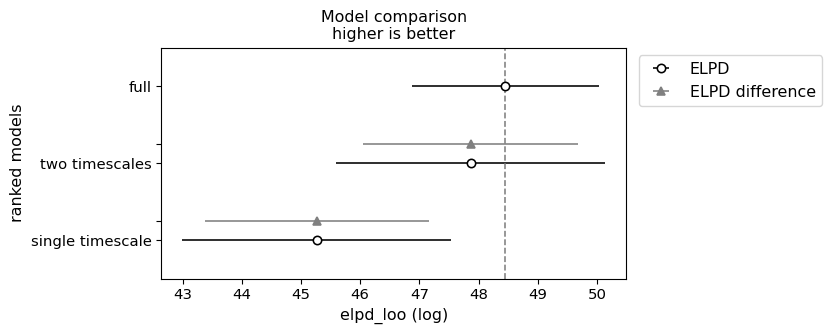

In [30]:
az.plot_compare(comp_loo, insample_dev=False);
plt.savefig("model_comparison.pdf", bbox_inches='tight')

In [31]:
model_waic = az.waic(trace)
model_single_waic = az.waic(trace_single)
model_tt_waic = az.waic(trace_tt)

comp_waic = az.compare({"full": trace, "single timescale": trace_single, "two timescales": trace_tt}, ic="waic")
comp_waic

/opt/homebrew/anaconda3/lib/python3.10/site-packages/arviz/stats/stats.py:1632: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.10/site-packages/arviz/stats/stats.py:1632: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.10/site-packages/arviz/stats/stats.py:1632: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.10/site-packages/arviz/stats/stats.py:1632: UserWarning: F

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
full,0,48.991434,3.460836,0.000000,5.897769e-01,1.487670,0.000000,True,log
two timescales,1,48.558166,3.378479,0.433268,4.102231e-01,2.044052,1.759152,True,log
single timescale,2,45.845142,3.259671,3.146292,2.220446e-16,1.939631,1.643287,True,log


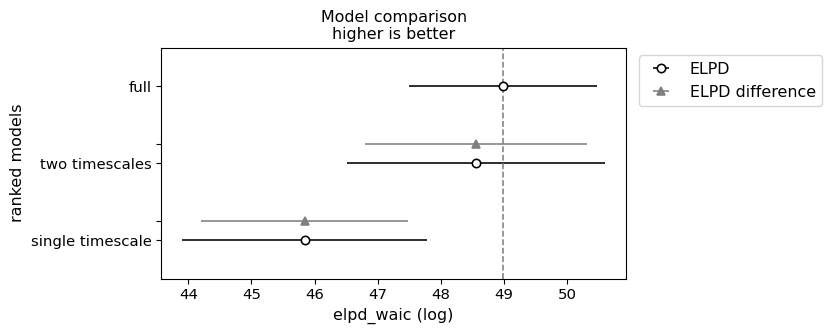

In [32]:
az.plot_compare(comp_waic, insample_dev=False);